In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


In [2]:
n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})


In [3]:
y = pd.Series(df["sales"].values, index=df["date"]).astype(float)

split = int(len(y) * 0.8)
train = y.iloc[:split]
test  = y.iloc[split:]


In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
test_scaled  = scaler.transform(test.values.reshape(-1,1)).astype(np.float32)


In [5]:
LOOKBACK = 30

def make_sequences(arr, lookback):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X[:, None, :], y[:, None]   # (B, C=1, T)

X_train, y_train = make_sequences(train_scaled, LOOKBACK)


In [7]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dl = DataLoader(SeqDataset(X_train, y_train), batch_size=32, shuffle=True)


In [8]:
class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_ch, out_ch,
            kernel_size,
            padding=padding,
            dilation=dilation
        )
        self.relu = nn.ReLU()
        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :-self.conv.padding[0]]  # causal cut
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


In [9]:
class TCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            TemporalBlock(1, 32, kernel_size=3, dilation=1),
            TemporalBlock(32, 32, kernel_size=3, dilation=2),
            TemporalBlock(32, 32, kernel_size=3, dilation=4)
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        out = self.net(x)
        return self.fc(out[:, :, -1])

model = TCN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [10]:
EPOCHS = 25
model.train()

for epoch in range(1, EPOCHS + 1):
    losses = []
    for xb, yb in dl:
        xb = xb.to(device).float()
        yb = yb.to(device).float()

        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | loss {np.mean(losses):.6f}")


epoch 01 | loss 0.105307
epoch 05 | loss 0.023994
epoch 10 | loss 0.011822
epoch 15 | loss 0.006471
epoch 20 | loss 0.004733
epoch 25 | loss 0.004193


In [11]:
model.eval()
window = train_scaled[-LOOKBACK:].copy()
preds_scaled = []

for _ in range(len(test)):
    X = torch.from_numpy(window.reshape(1,1,LOOKBACK)).float().to(device)
    with torch.no_grad():
        yhat = model(X).cpu().numpy()[0,0]
    preds_scaled.append(yhat)
    window = np.vstack([window[1:], [[yhat]]])

pred = scaler.inverse_transform(
    np.array(preds_scaled).reshape(-1,1)
).reshape(-1)


In [12]:
mae  = mean_absolute_error(test.values, pred)
rmse = np.sqrt(mean_squared_error(test.values, pred))
mape = np.mean(np.abs((test.values - pred) / np.maximum(test.values, 1e-8))) * 100

print("TCN Metrics")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


TCN Metrics
MAE  : 4.96
RMSE : 5.73
MAPE : 5.82%


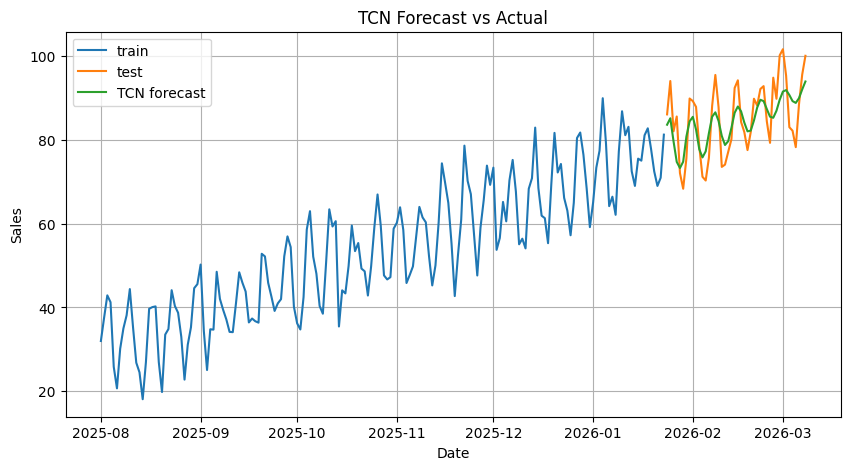

In [13]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(test.index, pred, label="TCN forecast")
plt.title("TCN Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.grid(True)
plt.show()
